When encountering the term Autoencoder for the first time, one might wonder, Is it like an SVD with non-linear twists?. Autoencoders are neural networks designed to learn compact representations of data. Their architecture consists of an encoder (which compresses input data) and a decoder (which reconstructs the original data). The goal? To find a lower-dimensional representation (the “bottleneck”) that captures essential features. Singular Value Decomposition (SVD) is a mathematical technique that decomposes a matrix into three components: $U$ , $\Sigma$, and $V$. The matrix $\Sigma$ contains the singular values, which determine each component’s importance. 

SVD operates linearly—no fancy activation functions. Unlike the linear SVD, autoencoders embrace non-linearity. By using activation functions like ReLU or sigmoid, they capture complex relationships in the data.

 
$
\begin{array}{|l|l|}
\hline
\textbf{Application} & \textbf{SVD} & \textbf{Autoencoder} \\
\hline
\text{Data Compression} & \text{Compresses data by retaining significant singular values.} & \text{Reduces high-dimensional data into a manageable form.} \\
\hline
\text{Image Recognition} & \text{Used for face recognition and image compression.} & \text{Denoises corrupted data.} \\
\hline
\text{Collaborative Filtering} & \text{Uncovers latent factors in user-item interactions.} & \text{N/A} \\
\hline
\text{Dimensionality Reduction} & \text{N/A} & \text{Excels at dimensionality reduction.} \\
\hline
\text{Noise Reduction} & \text{N/A} & \text{Denoises data by learning robust representations.} \\
\hline
\text{Image Generation} & \text{N/A} & \text{VAEs create new data samples.} \\
\hline
\end{array}
$

In [2]:
##Credict Card froud detection using autoencoder

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import polars as pl

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [3]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Binary Classification with an Autoencoder


The task of fraud detection for unsupervised data, particularly for credit card transactions, can be managed with a hybrid neural network approach. This can serve as an experimental case using data from a Kaggle dataset. The goal is to employ an autoencoder for binary classification, where the objective is to determine whether a transaction is fraudulent or not. The approach involves using the autoencoder to learn a latent representation and then applying a classifier on top of that representation.

In this case, the process should be as follows: Firts it whill train the Autoencoder for Feature Extraction using nn.MSELoss() to reconstruct the input data, then applied the Classifier for Binary Classification, were it will be utilized the features learned by the autoencoder (i.e., the encoded representation) as input to a separate classifier. This classifier, such as a neural network layer, should use nn.BCEWithLogitsLoss() for binary classification.

In [4]:
main_path = "credit_card/creditcard_2023.csv"

In [5]:
df = pd.read_csv(main_path)
#df = pl.read_csv(main_path)
df

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,568625,-0.833437,0.061886,-0.899794,0.904227,-1.002401,0.481454,-0.370393,0.189694,-0.938153,...,0.167503,0.419731,1.288249,-0.900861,0.560661,-0.006018,3.308968,0.081564,4394.16,1
568626,568626,-0.670459,-0.202896,-0.068129,-0.267328,-0.133660,0.237148,-0.016935,-0.147733,0.483894,...,0.031874,0.388161,-0.154257,-0.846452,-0.153443,1.961398,-1.528642,1.704306,4653.40,1
568627,568627,-0.311997,-0.004095,0.137526,-0.035893,-0.042291,0.121098,-0.070958,-0.019997,-0.122048,...,0.140788,0.536523,-0.211100,-0.448909,0.540073,-0.755836,-0.487540,-0.268741,23572.85,1
568628,568628,0.636871,-0.516970,-0.300889,-0.144480,0.131042,-0.294148,0.580568,-0.207723,0.893527,...,-0.060381,-0.195609,-0.175488,-0.554643,-0.099669,-1.434931,-0.159269,-0.076251,10160.83,1


In [173]:
# Normalize the "Amount" column
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# Filtrar los datos no fraudulentos (Class = 0)
df_non_fraud = df[df["Class"] == 0]



# 
X = df_non_fraud.drop(["id", "Class"], axis=1).values  
y = df_non_fraud["Class"].values

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mostrar dimensiones para verificar
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_test:", y_test.shape)

Dimensiones de X_train: (227452, 29)
Dimensiones de X_test: (56863, 29)
Dimensiones de y_train: (227452,)
Dimensiones de y_test: (56863,)


In [182]:

# Normalize the "Amount" column
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# Extract features and labels from the entire dataset
X = df.drop(["id", "Class"], axis=1).values  
y = df["Class"].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Filter non-fraudulent data (Class = 0) from the training set
X_train = X_train[y_train == 0]
y_train = y_train[y_train == 0]

# Display dimensions to verify
print("Dimensions of X_train_non_fraud:", X_train.shape)
print("Dimensions of X_test:", X_test.shape)
print("Dimensions of y_train_non_fraud:", y_train.shape)
print("Dimensions of y_test:", y_test.shape)


Dimensions of X_train_non_fraud: (255816, 29)
Dimensions of X_test: (56863, 29)
Dimensions of y_train_non_fraud: (255816,)
Dimensions of y_test: (56863,)


In [183]:
#Standarize data based on mean & std of X_train
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train -mean)/std
X_test = (X_test -mean)/std

In [189]:

# Pass the data to tensors

X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)  
y_test_tensor = torch.LongTensor(y_test)    


# Create DataLoader to handle data in batches
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


bs = 512
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=bs,
    shuffle=True,
    num_workers=8)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=bs,
    shuffle=False,
    num_workers=8)


## What is PCA?

PCA is a statistical procedure that transforms a dataset into a set of orthogonal (uncorrelated) components, called principal components. These components are ordered by the amount of variance they capture from the data. The first principal component captures the most variance, the second captures the second most, and so on.

Essentially I will going to project the high-dimensional data (before and after reconstruction) onto a lower-dimensional space for an easier interpretation. This can help in understanding how well the autoencoder is reconstructing the data by showing whether the reconstructed samples align with the original test samples in the reduced PCA space.

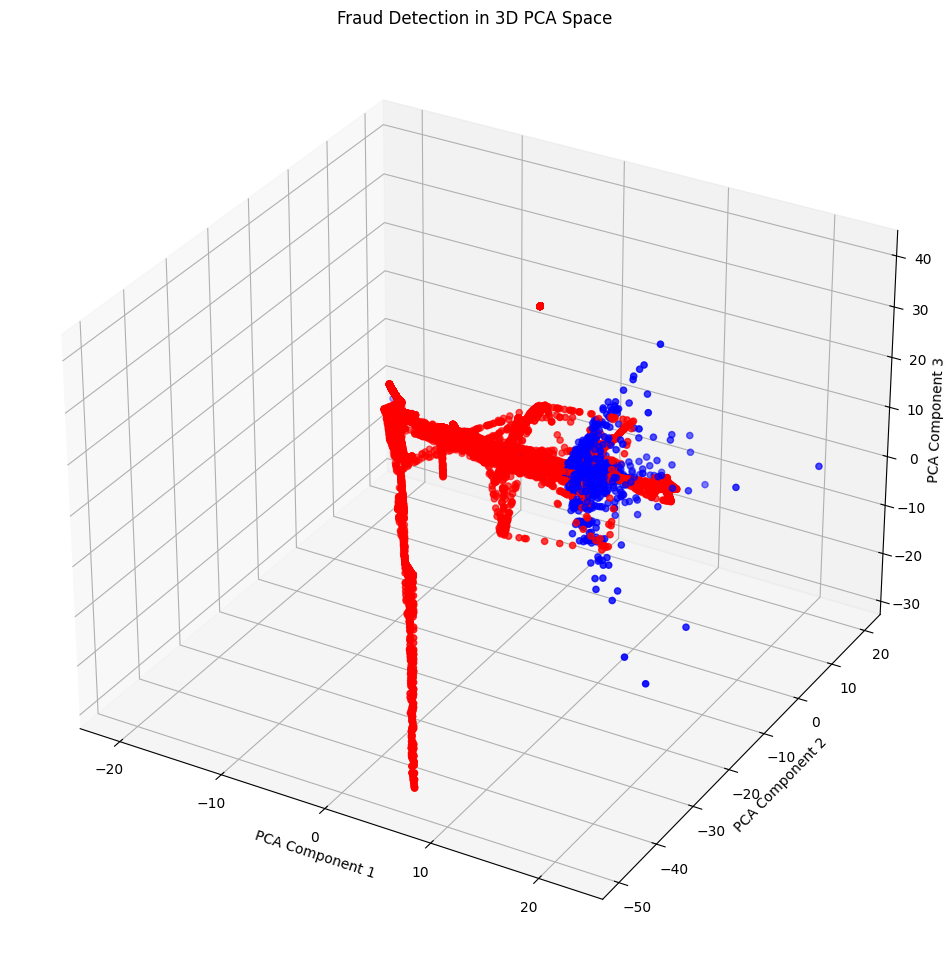

In [190]:
# Here we can see the test samples, and the final goals of the reconstruction in a PCA space
pca = PCA(n_components=3)
X_test_reduced = pca.fit_transform(X_test)

# 'r' anomaly  'b' normal
colors = ['r' if x == 1 else 'b' for x in y_test]

# 
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, projection='3d')

# 3D
scatter = ax.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], X_test_reduced[:, 2], 
                     c=colors, marker='o')

# Set axis labels and plot title
ax.set_xlabel('PCA Component 1', labelpad=1)
ax.set_ylabel('PCA Component 2', labelpad=1)
ax.set_zlabel('PCA Component 3', labelpad=0.5)
plt.title('Fraud Detection in 3D PCA Space', pad=1)

plt.show()


In [191]:
# ## Build the Autoencoder 

# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(29, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(32, 16),
#             nn.ReLU(),
#             nn.Linear(16, 8),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(8, 16),
#             nn.ReLU(),
#             nn.Linear(16, 32),
#             nn.ReLU(),
#             nn.Linear(32, 64),
#             nn.ReLU(),
#             nn.Linear(64, 29),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x


## Build the Autoencoder 

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(29, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 8)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 29),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [192]:

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(8, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
            nn.Linear(8, 1)  # Output layer for binary classification
        )
    
    def forward(self, x):
        x = self.classifier(x)
        return x  # Raw logits (not passed through sigmoid yet)


In [193]:
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
avg_losses = []
# Training loop for autoencoder
num_epochs = 200
for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0
    num_samples = 0

    for batch in train_loader:
        X_batch, _ = batch
        X_batch = X_batch.to(device)
        
        # Forward pass
        outputs = autoencoder(X_batch)
        loss = criterion(outputs, X_batch)
        
        # Backward and optimizez
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        num_samples += X_batch.size(0)

    avg_train_loss = train_loss / num_samples
    avg_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')



Epoch [1/200], Loss: 0.9571
Epoch [2/200], Loss: 0.9038
Epoch [3/200], Loss: 0.8930
Epoch [4/200], Loss: 0.8821
Epoch [5/200], Loss: 0.8708
Epoch [6/200], Loss: 0.8626
Epoch [7/200], Loss: 0.8564
Epoch [8/200], Loss: 0.8510
Epoch [9/200], Loss: 0.8453
Epoch [10/200], Loss: 0.8388
Epoch [11/200], Loss: 0.8322
Epoch [12/200], Loss: 0.8199
Epoch [13/200], Loss: 0.8124
Epoch [14/200], Loss: 0.8078
Epoch [15/200], Loss: 0.8034
Epoch [16/200], Loss: 0.7990
Epoch [17/200], Loss: 0.7943
Epoch [18/200], Loss: 0.7900
Epoch [19/200], Loss: 0.7870
Epoch [20/200], Loss: 0.7842
Epoch [21/200], Loss: 0.7805
Epoch [22/200], Loss: 0.7783
Epoch [23/200], Loss: 0.7765
Epoch [24/200], Loss: 0.7748
Epoch [25/200], Loss: 0.7725
Epoch [26/200], Loss: 0.7682
Epoch [27/200], Loss: 0.7629
Epoch [28/200], Loss: 0.7601
Epoch [29/200], Loss: 0.7584
Epoch [30/200], Loss: 0.7570
Epoch [31/200], Loss: 0.7551
Epoch [32/200], Loss: 0.7526
Epoch [33/200], Loss: 0.7510
Epoch [34/200], Loss: 0.7497
Epoch [35/200], Loss: 0

In [194]:
#Extract Features

autoencoder.eval()
features = []
labels = []

with torch.no_grad():
    for batch in train_loader:
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        feature = autoencoder.encoder(X_batch)
        features.append(feature.cpu())
        labels.append(y_batch.cpu())

features = torch.cat(features)
labels = torch.cat(labels)


In [210]:
#Train the Classifier:


classifier = Classifier().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# Training loop for classifier
num_epochs = 1
for epoch in range(num_epochs):
    classifier.train()
    train_loss = 0
    num_samples = 0

    for i in range(0, len(features), bs):
        feature_batch = features[i:i+bs].to(device)
        label_batch = labels[i:i+bs].to(device)
        
        # Forward pass
        logits = classifier(feature_batch)
        loss = criterion(logits.squeeze(), label_batch.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * feature_batch.size(0)
        num_samples += feature_batch.size(0)

    avg_train_loss = train_loss / num_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')



Epoch [1/1], Loss: 0.0403


In [217]:
contador = [values for values in y_test if values==1]
len(contador)

28364

In [224]:
#  reconstruction error on the training set
criterion = nn.MSELoss()

with torch.no_grad():
    X_train_tensor=X_train_tensor.to(device)
    reconstructions = autoencoder(X_train_tensor)

    train_loss = criterion(reconstructions, X_train_tensor)
print(f'Training set loss: {train_loss.item():.4f}')

# threshold as a multiple of the training set loss
threshold = train_loss.item() * 1.25
print(f'Set threshold: {threshold:.4f}')

# Detect anomalies on the test set
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    reconstructions = autoencoder(X_test_tensor)
    test_loss = torch.mean((reconstructions - X_test_tensor) ** 2, dim=1)

anomalies = test_loss > threshold
anomaly_indices = np.where(anomalies.cpu().numpy())[0]

print(f'Number of anomalies detected: {len(anomaly_indices)} vs Numger of anomalies: {len(contador)}')

from sklearn.metrics import precision_score, recall_score, f1_score

# Create a list of predictions (1 for anomaly, 0 for normal)
y_pred = np.zeros_like(y_test)
y_pred[anomaly_indices] = 1

# Evaluate the system
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Training set loss: 0.6841
Set threshold: 0.8551
Number of anomalies detected: 28459 vs Numger of anomalies: 28364
Precision: 0.8889
Recall: 0.8919
F1 Score: 0.8904


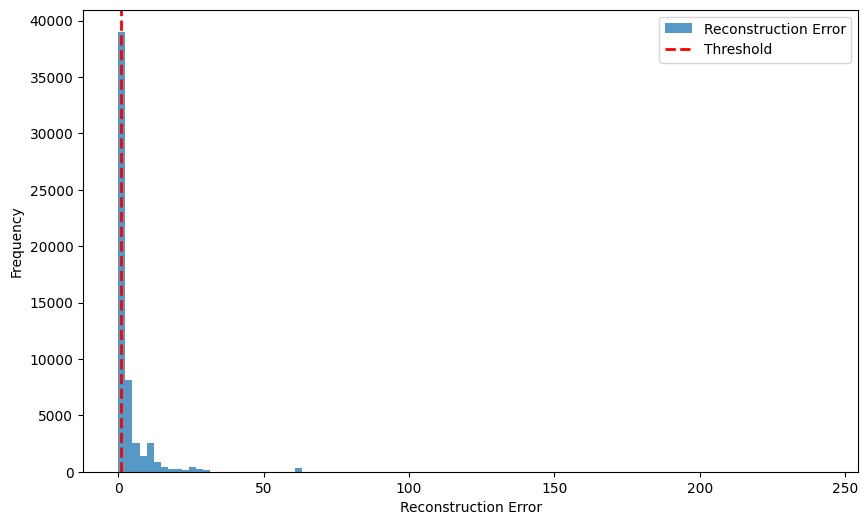

In [225]:
# Plot reconstruction error
plt.figure(figsize=(10, 6))
plt.hist(test_loss.cpu().numpy(), bins=100, alpha=0.75, label='Reconstruction Error')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [229]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set the model to evaluation mode
autoencoder.eval()

# Compute reconstruction errors for the test set
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    reconstructions = autoencoder(X_test_tensor)
    
    # Calculate reconstruction loss for each sample
    reconstruction_errors = torch.mean((reconstructions - X_test_tensor) ** 2, dim=1).cpu().numpy()

# Convert true labels to numpy array
y_true = y_test_tensor.cpu().numpy()

Set threshold: 0.9577


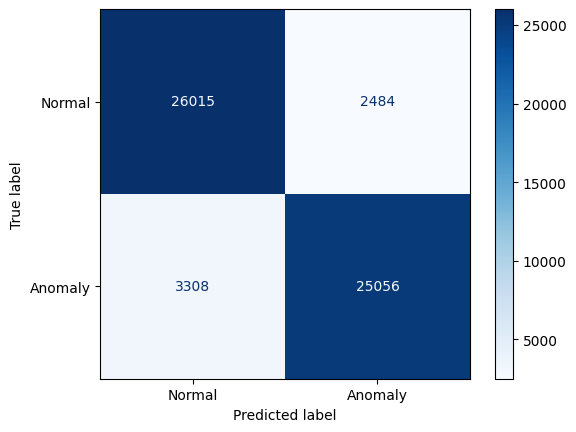

In [238]:
# Recycle code from above
threshold = train_loss.item() * 1.4
print(f'Set threshold: {threshold:.4f}')

# Create binary labels based on the threshold
y_pred = (reconstruction_errors > threshold).astype(int)

# Convert true labels to binary if necessary
# '1' represents anomaly
y_true_binary = (y_true == 1).astype(int)  

# Compute confusion matrix
cm = confusion_matrix(y_true_binary, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap='Blues', values_format='d')

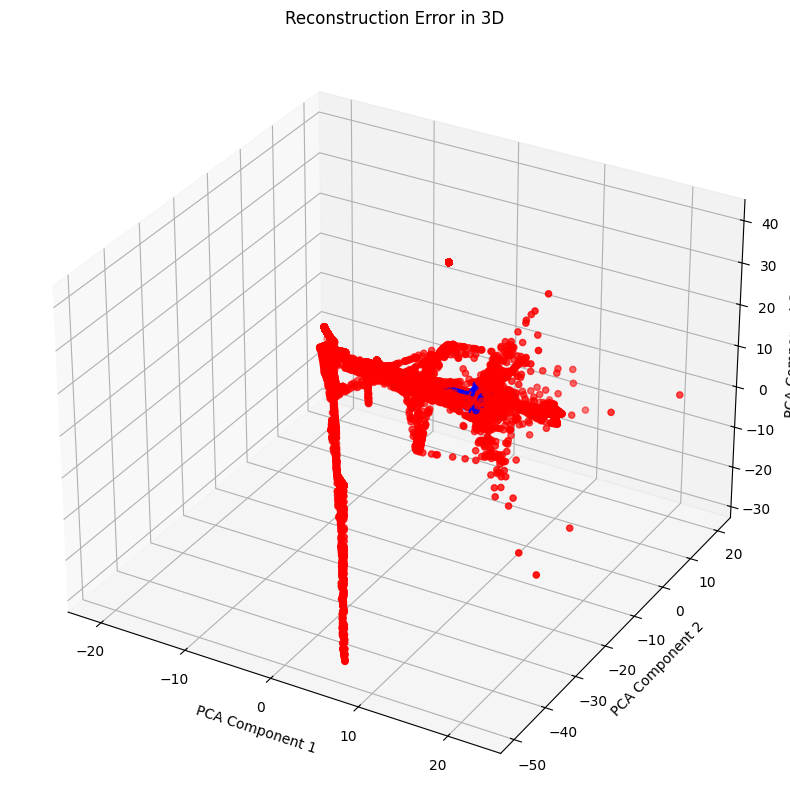

In [239]:
# 
pca = PCA(n_components=3)
X_test_reduced = pca.fit_transform(X_test)

# colores para los puntos, 'r' para anomalías y 'b' para normales
colors = ['r' if x else 'b' for x in anomalies.cpu().numpy()]

# 
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 3D
scatter = ax.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], X_test_reduced[:, 2], 
                     c=colors, marker='o')

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('Reconstruction Error in 3D')

# Mostrar la gráfica
plt.show()
